Found 6563 validated image filenames belonging to 38 classes.
Found 2188 validated image filenames belonging to 38 classes.
Found 10547 validated image filenames belonging to 38 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 64s 470ms/step - accuracy: 0.2616 - loss: 5.9138 - val_accuracy: 0.1325 - val_loss: 3.5667
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.4372 - loss: 3.3396 - val_accuracy: 0.1668 - val_loss: 3.2790
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 222ms/step - accuracy: 0.4858 - loss: 2.7922 - val_accuracy: 0.1961 - val_loss: 2.8698
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - accuracy: 0.5259 - loss: 2.5085 - val_accuracy: 0.3277 - val_loss: 2.4567
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.5700 - loss: 2.2607 - val_accuracy: 0.4803 - val_loss: 1.8849
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 124s 628ms/step - accuracy: 0.4483 - loss: 3.4988 - val_accuracy: 0.0142 - val_loss: 8.8602
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 327ms/step - accuracy: 0.8685 - loss: 0.3906 - val_accuracy: 0.0229 - val_loss: 15.0305
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 331ms/step - accuracy: 0.9441 - loss: 0.1467 - val_a

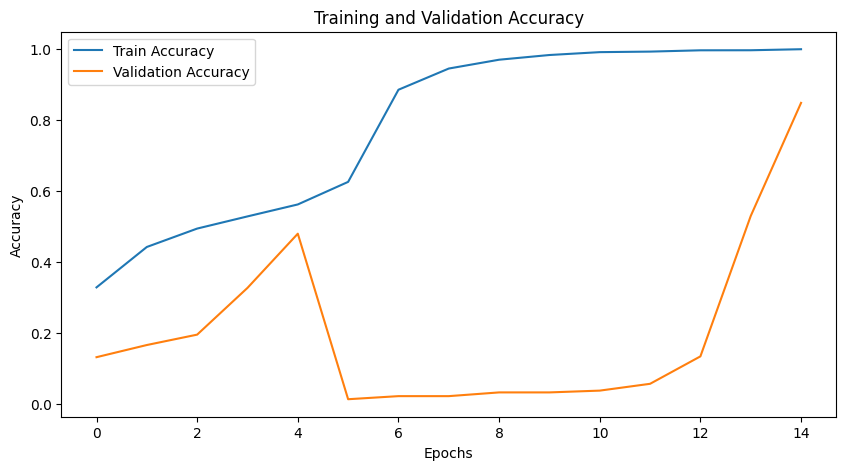

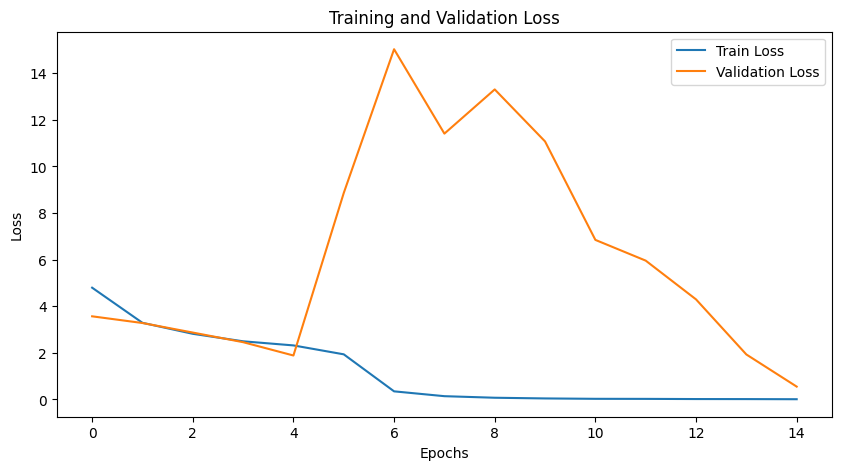

165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step


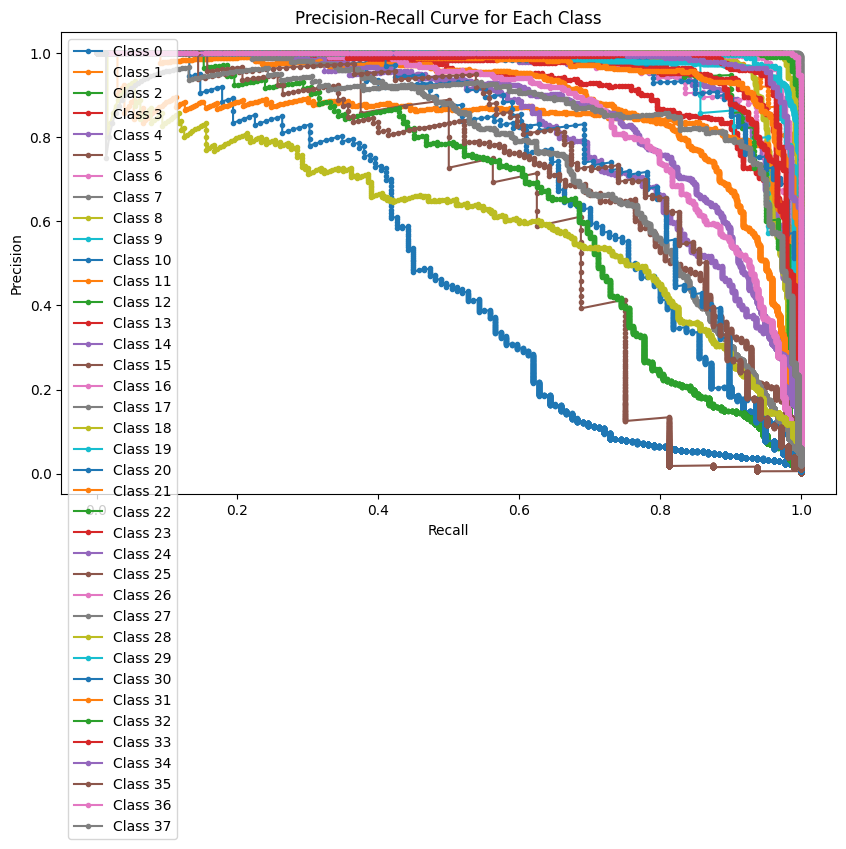

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/plantvillage-dataset/data_distribution_for_SVM"

# Load dataset
all_images, all_labels = [], []
label_map = {str(i): i for i in range(38)}

train_folder = os.path.join(dataset_path, "train")
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

test_imgs, test_labels = [], []
test_folder = os.path.join(dataset_path, "test")
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    for img_file in os.listdir(label_path):
        test_imgs.append(os.path.join(label_path, img_file))
        test_labels.append(label_map[label])

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Image data generator
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=64, class_mode="sparse")
val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=64, class_mode="sparse")
test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=64, class_mode="sparse", shuffle=False)

# Define ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model initially

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(38, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer=Adam(learning_rate=0.0007), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model (Initial training with frozen base model)
history = model.fit(train_gen, validation_data=val_gen, epochs=5, class_weight=class_weight_dict)

# Unfreeze some layers and fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=10, class_weight=class_weight_dict)

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Combine history metrics
full_train_acc = history.history['accuracy'] + history_finetune.history['accuracy']
full_val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
full_train_loss = history.history['loss'] + history_finetune.history['loss']
full_val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(full_train_acc, label='Train Accuracy')
plt.plot(full_val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training/validation loss
plt.figure(figsize=(10, 5))
plt.plot(full_train_loss, label='Train Loss')
plt.plot(full_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Compute and plot PR curve
y_true = tf.keras.utils.to_categorical(test_gen.classes, 38)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(38):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()
